In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = 'Dataset/mental_health_dataset.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset Loaded Successfully")
except FileNotFoundError:
    print(f"Error: File was not found")
    exit()

Dataset Loaded Successfully


In [3]:
df_cleaned = df.copy()

## Dealing with age null value

if df_cleaned['age'].isnull().any():
    median_age = df_cleaned['age'].median()
    df_cleaned['age'] = df_cleaned['age'].fillna(median_age)
    print(f"Filled missing age values with median: {median_age}")

Filled missing age values with median: 67.0


In [4]:
## Dealing with condition type missing values

if df_cleaned['condition_type'].isnull().any():
    mode_condition_type = df_cleaned['condition_type'].mode()[0]
    df_cleaned['condition_type'] = df_cleaned['condition_type'].fillna(mode_condition_type)
    print(f"filled missing condition_type values with mode: {mode_condition_type}")

filled missing condition_type values with mode: Breast


In [5]:
## Dealing with bdi_ii_baseline missing values

if df_cleaned['bdi_ii_baseline'].isnull().any():
    median_baseline = df_cleaned['bdi_ii_baseline'].median()
    df_cleaned['bdi_ii_baseline'] = df_cleaned['bdi_ii_baseline'].fillna(median_baseline)
    print(f"Filled missing values with the median values: {median_baseline}")

Filled missing values with the median values: 10.0


## Feature Engineering

Creating a new column session_completion_rate so that it can make an impact.

In [6]:
df_cleaned['session_completion_rate'] = df_cleaned['mindfulness_therapies_completed'] / df_cleaned['mindfulness_therapies_started']

# Handle cases where therapies_started is 0 to avoid division by zero errors.
df_cleaned['session_completion_rate'] = df_cleaned['session_completion_rate'].fillna(0)
print("Created 'session_completion_rate' feature.")

Created 'session_completion_rate' feature.


In [7]:
cat_cols = ["sex", "condition", "condition_type", "hospital_center_id"]
for c in cat_cols:
    df_cleaned[c] = df_cleaned[c].astype("category")

# Previewing unique values (to sanity check)
for c in cat_cols:
    print(f"\n{c} -> {df_cleaned[c].nunique()} unique values")
    print(df_cleaned[c].cat.categories.tolist()[:10])  # show up to first 10 categories


sex -> 2 unique values
['female', 'male']

condition -> 4 unique values
['Acute coronary syndrome', 'Cancer', 'Lower-limb amputation', 'Renal insufficiency']

condition_type -> 7 unique values
['Breast', 'Dialysis', 'No prosthesis', 'Percutaneous coronary intervention', 'Predialysis', 'Prostate', 'Revascularization']

hospital_center_id -> 3 unique values
[1, 2, 3]


In [8]:
df_encoded = df_cleaned.copy()

In [9]:
sex_mapping = {'female': 0, 'male': 1}
df_encoded['sex'] = df_encoded['sex'].map(sex_mapping)
print("Applied Label Encoding to 'sex' column.")

Applied Label Encoding to 'sex' column.


In [10]:
cat_cols1 = ['condition', 'condition_type', 'hospital_center_id']
df_encoded = pd.get_dummies(df_encoded, columns=cat_cols1, prefix=cat_cols1, dtype=int)
print("Applied One-Hot Encoding to 'condition', 'condition_type', and 'hospital_center_id'.")

Applied One-Hot Encoding to 'condition', 'condition_type', and 'hospital_center_id'.


## Model Training

In [11]:
import shap

def run_shap_analysis(model, X_test, model_name, target_name):
    """
    Performs SHAP analysis on the best model to explain feature importance.
    """
    print(f"\n--- Running SHAP Analysis for {model_name} on {target_name} ---")
   
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
   
    # Generate the SHAP summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP Feature Importance for {target_name}\n(Model: {model_name})", fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [13]:
import numpy as np
def create_features(df_to_feature):
    df_to_feature["delta_12w"] = df_to_feature["bdi_ii_baseline"] - df_to_feature["bdi_ii_after_intervention_12w"]
    df_to_feature["delta_24w"] = df_to_feature["bdi_ii_baseline"] - df_to_feature["bdi_ii_follow_up_24w"]
    df_to_feature["pct_improve_12w"] = np.where(df_to_feature["bdi_ii_baseline"] > 0, 100 * df_to_feature["delta_12w"] / df_to_feature["bdi_ii_baseline"], np.nan)
    df_to_feature["pct_improve_24w"] = np.where(df_to_feature["bdi_ii_baseline"] > 0, 100 * df_to_feature["delta_24w"] / df_to_feature["bdi_ii_baseline"], np.nan)
    df_to_feature["completion_rate"] = np.where(df_to_feature["mindfulness_therapies_started"] > 0, df_to_feature["mindfulness_therapies_completed"] / df_to_feature["mindfulness_therapies_started"], 0)
    df_to_feature['completion_rate'] = df_to_feature['completion_rate'].fillna(0)
    return df_to_feature

## STOCHASTIC (MODEL-BASED + NOISE) IMPUTATION

In [14]:
def impute_with_noise(data, target_column):
    """
    Trains a model on known targets, predicts missing targets, adds random noise,
    and then fills the missing values.
    """
    print(f"\n--- Running Stochastic Imputation for: {target_column} ---")
   
    data_with_target = data[data[target_column].notna()]
    data_to_impute = data[data[target_column].isna()]


    if len(data_to_impute) == 0:
        print("No missing values to impute.")
        return data
       
    y_helper = data_with_target[target_column]
    cols_to_exclude = [
        'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w',
        'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w'
    ]
    X_helper = data_with_target.drop(columns=[col for col in cols_to_exclude if col in data_with_target.columns])
    X_to_impute = data_to_impute.drop(columns=[col for col in cols_to_exclude if col in data_to_impute.columns])

    numerical_cols = X_helper.select_dtypes(include=np.number).columns
    cols_to_scale = [col for col in numerical_cols if len(X_helper[col].unique()) > 2]
    
    scaler = StandardScaler()
    X_helper[cols_to_scale] = scaler.fit_transform(X_helper[cols_to_scale])
    X_to_impute[cols_to_scale] = scaler.transform(X_to_impute[cols_to_scale])


    helper_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    helper_model.fit(X_helper, y_helper)
   
    predicted_values = helper_model.predict(X_to_impute)
   
    # Create a random noise factor between 0.8 and 1.2 for each prediction
    noise_factor = np.random.uniform(0.8, 1.2, size=len(predicted_values))
    randomized_values = predicted_values * noise_factor
   
    # Ensure scores do not become negative after randomization
    randomized_values = np.maximum(0, randomized_values)
   
    imputed_data = data.copy()
    imputed_data.loc[imputed_data[target_column].isna(), target_column] = randomized_values
   
    print(f"Successfully imputed {len(data_to_impute)} missing values with noise.")
    return imputed_data


# --- Run the imputation process for both target variables ---
df_imputed_noisy = impute_with_noise(df_encoded, 'bdi_ii_after_intervention_12w')
df_imputed_noisy = impute_with_noise(df_imputed_noisy, 'bdi_ii_follow_up_24w')


# --- Recalculate features with the new imputed data ---
df_final = create_features(df_imputed_noisy)
print("\n--- Imputation Complete and Features Recalculated ---")


--- Running Stochastic Imputation for: bdi_ii_after_intervention_12w ---
Successfully imputed 43 missing values with noise.

--- Running Stochastic Imputation for: bdi_ii_follow_up_24w ---
Successfully imputed 44 missing values with noise.

--- Imputation Complete and Features Recalculated ---


## Using SHAP analysis and Regression Coefficients for interpreting model output

In [15]:
def run_interpretation(model, model_name, X_data, target_name):
    """
    Generates and saves a feature importance plot for the given model.
    Handles both linear (coefficients) and tree-based (SHAP) models.
    """
    plt.figure(figsize=(10, 8))


    if model_name == "Ridge Regression":
        # For linear models, we plot the coefficients directly
        try:
            coefficients = pd.Series(model.coef_, index=X_data.columns)
            # Plot top 20 most important features
            sorted_coeffs = coefficients.abs().sort_values(ascending=False).head(20)
            coefficients[sorted_coeffs.index].sort_values().plot(kind='barh')
            plt.title(f'Feature Importance for {target_name}\n(Model: Ridge Regression Coefficients)')
           
        except Exception as e:
            print(f"Could not plot coefficients for Ridge Regression: {e}")
            return
           
    else: # For tree-based models, use SHAP
        try:
            print(f"  > Calculating SHAP values for {model_name}...")
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_data)
           
            shap.summary_plot(shap_values, X_data, show=False, plot_size=None)
            plt.title(f'SHAP Feature Importance for {target_name}\n(Model: {model_name})')


        except Exception as e:
            print(f"Could not generate SHAP plot for {model_name}: {e}")
            return


    # Final plot adjustments and saving
    plt.tight_layout()
    # Sanitize filename
    safe_target_name = target_name.replace(' ', '_').replace('/', '_')
    safe_model_name = model_name.replace(' ', '_')
    plt.savefig(f'figures/Importance_{safe_target_name}_{safe_model_name}.png', dpi=300)
    plt.show()

In [16]:
def run_interpretation_modified(model, model_name, X_data, target_name, subgroup_title=None, ax=None):
    """
    Generates a feature importance plot. Can plot on a given matplotlib axis.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        show_plot = True
    else:
        show_plot = False


    plot_title = f'Importance for {target_name}'
    if subgroup_title:
        plot_title = f'Importance for Subgroup: {subgroup_title}'


    # Case 1: If it's a linear model, use coefficients.
    if "Ridge" in model_name:
        importances = pd.Series(model.coef_, index=X_data.columns)
        plot_df = importances.abs().sort_values(ascending=False).head(15)
        importances[plot_df.index].sort_values().plot(kind='barh', ax=ax)
        ax.set_title(plot_title + f'\n(Model: Ridge Coefficients)')

    # Case 2: If it's a tree-based model, use feature_importances_.
    else:
        importances = pd.Series(model.feature_importances_, index=X_data.columns)
        # We plot the top 15 features by importance
        plot_df = importances.sort_values(ascending=False).head(15)
        plot_df.sort_values().plot(kind='barh', ax=ax) # sort_values() makes the biggest bar appear on top
        ax.set_title(plot_title + f'\n(Model: {model_name} Importance)')

    if show_plot:
        plt.tight_layout()
        plt.show()

In [17]:
from sklearn.model_selection import train_test_split

def final_train_and_evaluate(data, target_column):
    """
    This function takes the fully imputed data and a target column name,
    then trains and evaluates a suite of regression models.
    """
    print(f"\n{'='*30}")
    print(f"  FINAL MODELING FOR: {target_column}")
    print(f"{'='*30}\n")
   
    # Define features (X) and target (y)
    y = data[target_column]
    cols_to_exclude = [
        'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w',
        'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w'
    ]
    X = data.drop(columns=[col for col in cols_to_exclude if col in data.columns])


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training on {len(X_train)} samples, testing on {len(X_test)} samples.")
   
    models = {
        "Ridge Regression": Ridge(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42, n_jobs=-1),
        "XGBoost": XGBRegressor(random_state=42, n_jobs=-1, verbosity=0),  # silence xgboost
        "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),  # silence LightGBM
        "CatBoost": CatBoostRegressor(random_state=42, verbose=0) 
    }
   
    results = []
   
    best_model = None
    best_model_name = ""
    best_rmse = float('inf')

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        results.append({"Model": name, "RMSE": rmse, "R-squared": r2})
       
        # Check if this is the best model so far
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_model_name = name
           
    results_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True).reset_index(drop=True)
    print("\n--- Model Performance Results ---")
    print(results_df)
    print(f"\nBEST GlobalMODEL: {best_model_name} with RMSE: {best_rmse:.4f}")

    print(f"--- Generating Feature Importance for Best Global Model ({best_model_name}) ---")
    run_interpretation_modified(best_model, best_model_name, X_test, target_column)

In [18]:
df_final["sex"] = df_encoded["sex"].astype(int)

## Subgroup Analysis Methodology

In [19]:
def run_subgroup_analysis(data, target_column):
    """
    Filters data for a comprehensive list of disease groups, trains a dedicated model for each,
    and generates a dynamic grid of feature importance plots for comparison.
    """
    print(f"\n{'='*40}")
    print(f"  RUNNING DETAILED SUBGROUP ANALYSIS FOR: {target_column}")
    print(f"{'='*40}\n")

    # Define the comprehensive list of subgroups
    subgroups = {
        'Acute Coronary Syndrome': 'condition_Acute coronary syndrome',
        'Cancer': 'condition_Cancer',
        'Breast Cancer': 'condition_type_Breast',
        'Prostate Cancer': 'condition_type_Prostate',
        'Renal Insufficiency': 'condition_Renal insufficiency',
        'Dialysis': 'condition_type_Dialysis',
        'Predialysis': 'condition_type_Predialysis',
        'Lower-limb Amputation': 'condition_Lower-limb amputation',
        'No Prosthesis': 'condition_type_No prosthesis',
        'Revascularization': 'condition_type_Revascularization',
        'Percutaneous Coronary Intervention': 'condition_type_Percutaneous coronary intervention'
    }

    # 1. DYNAMICALLY CALCULATE GRID SIZE
    # Determine the number of rows and columns needed for the plot grid.
    num_subgroups = len(subgroups)
    cols = 3  # Set a fixed number of columns for a clean layout
    rows = int(np.ceil(num_subgroups / cols)) # Calculate rows needed

    # 2. ADJUST FIGURE SIZE BASED ON NUMBER OF ROWS
    # Make the figure taller to accommodate more plots without squishing them.
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 6))
    axes = axes.flatten() # Flatten the grid of axes for easy iteration

    for i, (group_name, col_name) in enumerate(subgroups.items()):
        ax = axes[i]
        print(f"--- Analyzing Subgroup: {group_name} ---")

        if col_name not in data.columns:
            print(f"Warning: Column '{col_name}' not found. Skipping.")
            ax.text(0.5, 0.5, f'Column not found:\n{col_name}', ha='center', va='center', fontsize=10, color='red')
            ax.set_title(f"Subgroup: {group_name} (Error)")
            continue

        subgroup_df = data[data[col_name] == 1].copy()

        if len(subgroup_df) < 10:
            print(f"Warning: Not enough data for {group_name} (found {len(subgroup_df)} samples).")
            ax.text(0.5, 0.5, f'Not enough data\n({len(subgroup_df)} samples)', ha='center', va='center', fontsize=10)
            ax.set_title(f"Subgroup: {group_name}")
            continue
        
        print(f"Found {len(subgroup_df)} samples for this group.")
        
        y_sub = subgroup_df[target_column]
        cols_to_exclude = [
            'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w',
            'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w'
        ]
        X_sub = subgroup_df.drop(columns=[col for col in cols_to_exclude if col in subgroup_df.columns])
        
        model_sub = LGBMRegressor(random_state=42, verbose = -1)
        model_sub.fit(X_sub, y_sub)
        
        run_interpretation_modified(
            model=model_sub, 
            model_name="LightGBM Regressor", 
            X_data=X_sub, 
            target_name=target_column, 
            subgroup_title=group_name, 
            ax=ax
        )
    
    # 3. HIDE UNUSED SUBPLOTS
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle('Side-by-Side Subgroup Feature Importance Comparison', fontsize=24, y=1.02)
    plt.tight_layout(pad=3.0)
    plt.show()

In [ ]:
def generate_focused_subgroup_plot(data):
    """
    Generates a focused 3x2 comparison plot for the most insightful subgroups,
    comparing their 12-week (Ridge) and 24-week (LightGBM) feature importances.
    """
    print("\n" + "="*40)
    print("  GENERATING FOCUSED SUBGROUP COMPARISON PLOT")
    print("="*40 + "\n")

    # 1. DEFINE THE KEY SUBGROUPS AND TARGETS TO PLOT
    subgroups_to_plot = {
        'Acute Coronary Syndrome': 'condition_Acute coronary syndrome',
        'Breast Cancer': 'condition_type_Breast',
        'Renal Insufficiency': 'condition_Renal insufficiency'
    }
    
    targets = {
        '12 Weeks (Ridge)': 'bdi_ii_after_intervention_12w',
        '24 Weeks (LGBM)': 'bdi_ii_follow_up_24w'
    }

    # 2. CREATE THE PLOTTING GRID (3 rows for subgroups, 2 for timepoints)
    fig, axes = plt.subplots(len(subgroups_to_plot), 2, figsize=(18, 20))
    
    # Loop through each subgroup (for each row)
    for i, (group_name, col_name) in enumerate(subgroups_to_plot.items()):
        
        # Loop through each timepoint (for each column)
        for j, (title, target_col) in enumerate(targets.items()):
            ax = axes[i, j]
            
            subgroup_df = data[data[col_name] == 1].copy()
            
            if len(subgroup_df) < 10:
                ax.text(0.5, 0.5, f'Not enough data\n({len(subgroup_df)} samples)', ha='center', va='center')
                ax.set_title(f'{group_name}\n{title}')
                continue
                
            y_sub = subgroup_df[target_col]
            cols_to_exclude = [
                'bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w',
                'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w'
            ]
            X_sub = subgroup_df.drop(columns=[col for col in cols_to_exclude if col in subgroup_df.columns])
            
            if '12 Weeks' in title:
                model = Ridge(random_state=42)
                model_name = "Ridge Regression"
            else: # 24 Weeks
                model = LGBMRegressor(random_state=42, verbose=-1)
                model_name = "LightGBM Importance"
            
            model.fit(X_sub, y_sub)
            
            run_interpretation_modified( 
                model=model,
                model_name=model_name,
                X_data=X_sub,
                target_name="", # Title is handled by subplot
                subgroup_title=f'{group_name}\n({title})',
                ax=ax
            )

    # 3. FINAL FIGURE ADJUSTMENTS
    fig.suptitle('Disease-Specific Comparison: Evolving Predictors for Key Subgroups', fontsize=24, y=1.03)
    plt.tight_layout(pad=3.0)
    # plt.savefig('focused_subgroup_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def generate_disease_specific_plot(data):
    """
    Generates a compact 1x3 plot comparing the most insightful subgroups
    at the 12-week mark to highlight disease-specific differences.
    """
    print("\n" + "="*40)
    print("  GENERATING DISEASE-SPECIFIC COMPARISON PLOT (12 WEEKS)")
    print("="*40 + "\n")

    subgroups_to_plot = {
        'Acute Coronary Syndrome': 'condition_Acute coronary syndrome',
        'Breast Cancer': 'condition_type_Breast',
        'Renal Insufficiency': 'condition_Renal insufficiency'
    }

    fig, axes = plt.subplots(1, 3, figsize=(20, 6)) # Create a 1x3 grid

    for i, (group_name, col_name) in enumerate(subgroups_to_plot.items()):
        ax = axes[i]
        target_col = 'bdi_ii_after_intervention_12w'
        
        # --- Data Filtering ---
        subgroup_df = data[data[col_name] == 1].copy()
        
        if len(subgroup_df) < 10:
            ax.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
            ax.set_title(f'{group_name}\n(12 Weeks - Ridge)')
            continue
            
        y_sub = subgroup_df[target_col]
        cols_to_exclude = ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w', 'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w']
        X_sub = subgroup_df.drop(columns=[col for col in cols_to_exclude if col in subgroup_df.columns])
        
        # --- Model Training ---
        model = Ridge(random_state=42)
        model.fit(X_sub, y_sub)
        
        # --- Interpretation ---
        run_interpretation_modified(
            model=model,
            model_name="Ridge Regression",
            X_data=X_sub,
            target_name="",
            subgroup_title=f'{group_name}\n(12 Weeks)',
            ax=ax
        )

    fig.suptitle('Disease-Specific Comparison of Key Predictors at 12 Weeks', fontsize=18, y=1.05)
    plt.tight_layout(pad=2.0)
    # plt.savefig('disease_specific_comparison_12w.png', dpi=300, bbox_inches='tight')
    plt.show()



In [ ]:
def generate_temporal_shift_plot(data):
    """
    Generates a compact 1x2 plot for a single, representative subgroup to
    highlight the temporal shift in predictors from 12 to 24 weeks.
    """
    print("\n" + "="*40)
    print("  GENERATING TEMPORAL SHIFT PLOT (ACUTE CORONARY SYNDROME)")
    print("="*40 + "\n")

    group_name = 'Prostate Cancer'
    col_name = 'condition_type_Prostate'
    
    targets = {
        '12 Weeks (Ridge)': 'bdi_ii_after_intervention_12w',
        '24 Weeks (LGBM)': 'bdi_ii_follow_up_24w'
    }

    fig, axes = plt.subplots(1, 2, figsize=(16, 6)) # Create a 1x2 grid

    for i, (title, target_col) in enumerate(targets.items()):
        ax = axes[i]
        
        # --- Data Filtering ---
        subgroup_df = data[data[col_name] == 1].copy()
        y_sub = subgroup_df[target_col]
        cols_to_exclude = ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w', 'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w']
        X_sub = subgroup_df.drop(columns=[col for col in cols_to_exclude if col in subgroup_df.columns])
        
        # --- Model Selection & Training ---
        if '12 Weeks' in title:
            model = Ridge(random_state=42)
            model_name = "Ridge Regression"
        else:
            model = LGBMRegressor(random_state=42, verbose=-1)
            model_name = "LightGBM Importance"
        
        model.fit(X_sub, y_sub)
        
        # --- Interpretation ---
        run_interpretation_modified(
            model=model,
            model_name=model_name,
            X_data=X_sub,
            target_name="",
            subgroup_title=title,
            ax=ax
        )

    fig.suptitle(f'Temporal Shift in Predictors for {group_name}', fontsize=18, y=1.05)
    plt.tight_layout(pad=2.0)
    # plt.savefig('temporal_shift_acs.png', dpi=300, bbox_inches='tight')
    plt.show()


In [23]:
df_final = df_final.drop(columns=['completion_rate'])


  FINAL MODELING FOR: bdi_ii_after_intervention_12w

Training on 168 samples, testing on 42 samples.

--- Model Performance Results ---
              Model      RMSE  R-squared
0  Ridge Regression  5.453288   0.443508
1          LightGBM  5.666581   0.399125
2          CatBoost  5.886627   0.351552
3     Random Forest  5.963558   0.334492
4           XGBoost  6.127538   0.297390

BEST GlobalMODEL: Ridge Regression with RMSE: 5.4533
--- Generating Feature Importance for Best Global Model (Ridge Regression) ---


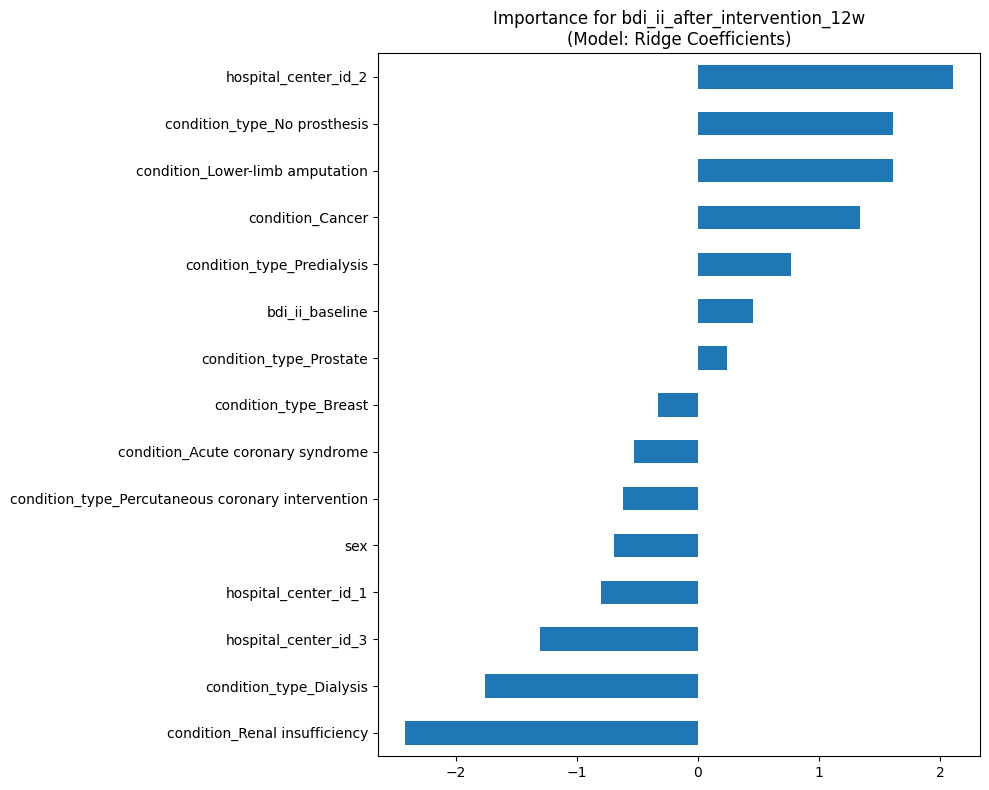

In [24]:
final_train_and_evaluate(df_final, 'bdi_ii_after_intervention_12w')


  RUNNING DETAILED SUBGROUP ANALYSIS FOR: bdi_ii_after_intervention_12w

--- Analyzing Subgroup: Acute Coronary Syndrome ---
Found 52 samples for this group.
--- Analyzing Subgroup: Cancer ---
Found 127 samples for this group.
--- Analyzing Subgroup: Breast Cancer ---
Found 79 samples for this group.
--- Analyzing Subgroup: Prostate Cancer ---
Found 49 samples for this group.
--- Analyzing Subgroup: Renal Insufficiency ---
Found 19 samples for this group.
--- Analyzing Subgroup: Dialysis ---
--- Analyzing Subgroup: Predialysis ---
Found 17 samples for this group.
--- Analyzing Subgroup: Lower-limb Amputation ---
Found 12 samples for this group.
--- Analyzing Subgroup: No Prosthesis ---
Found 12 samples for this group.
--- Analyzing Subgroup: Revascularization ---
Found 43 samples for this group.
--- Analyzing Subgroup: Percutaneous Coronary Intervention ---


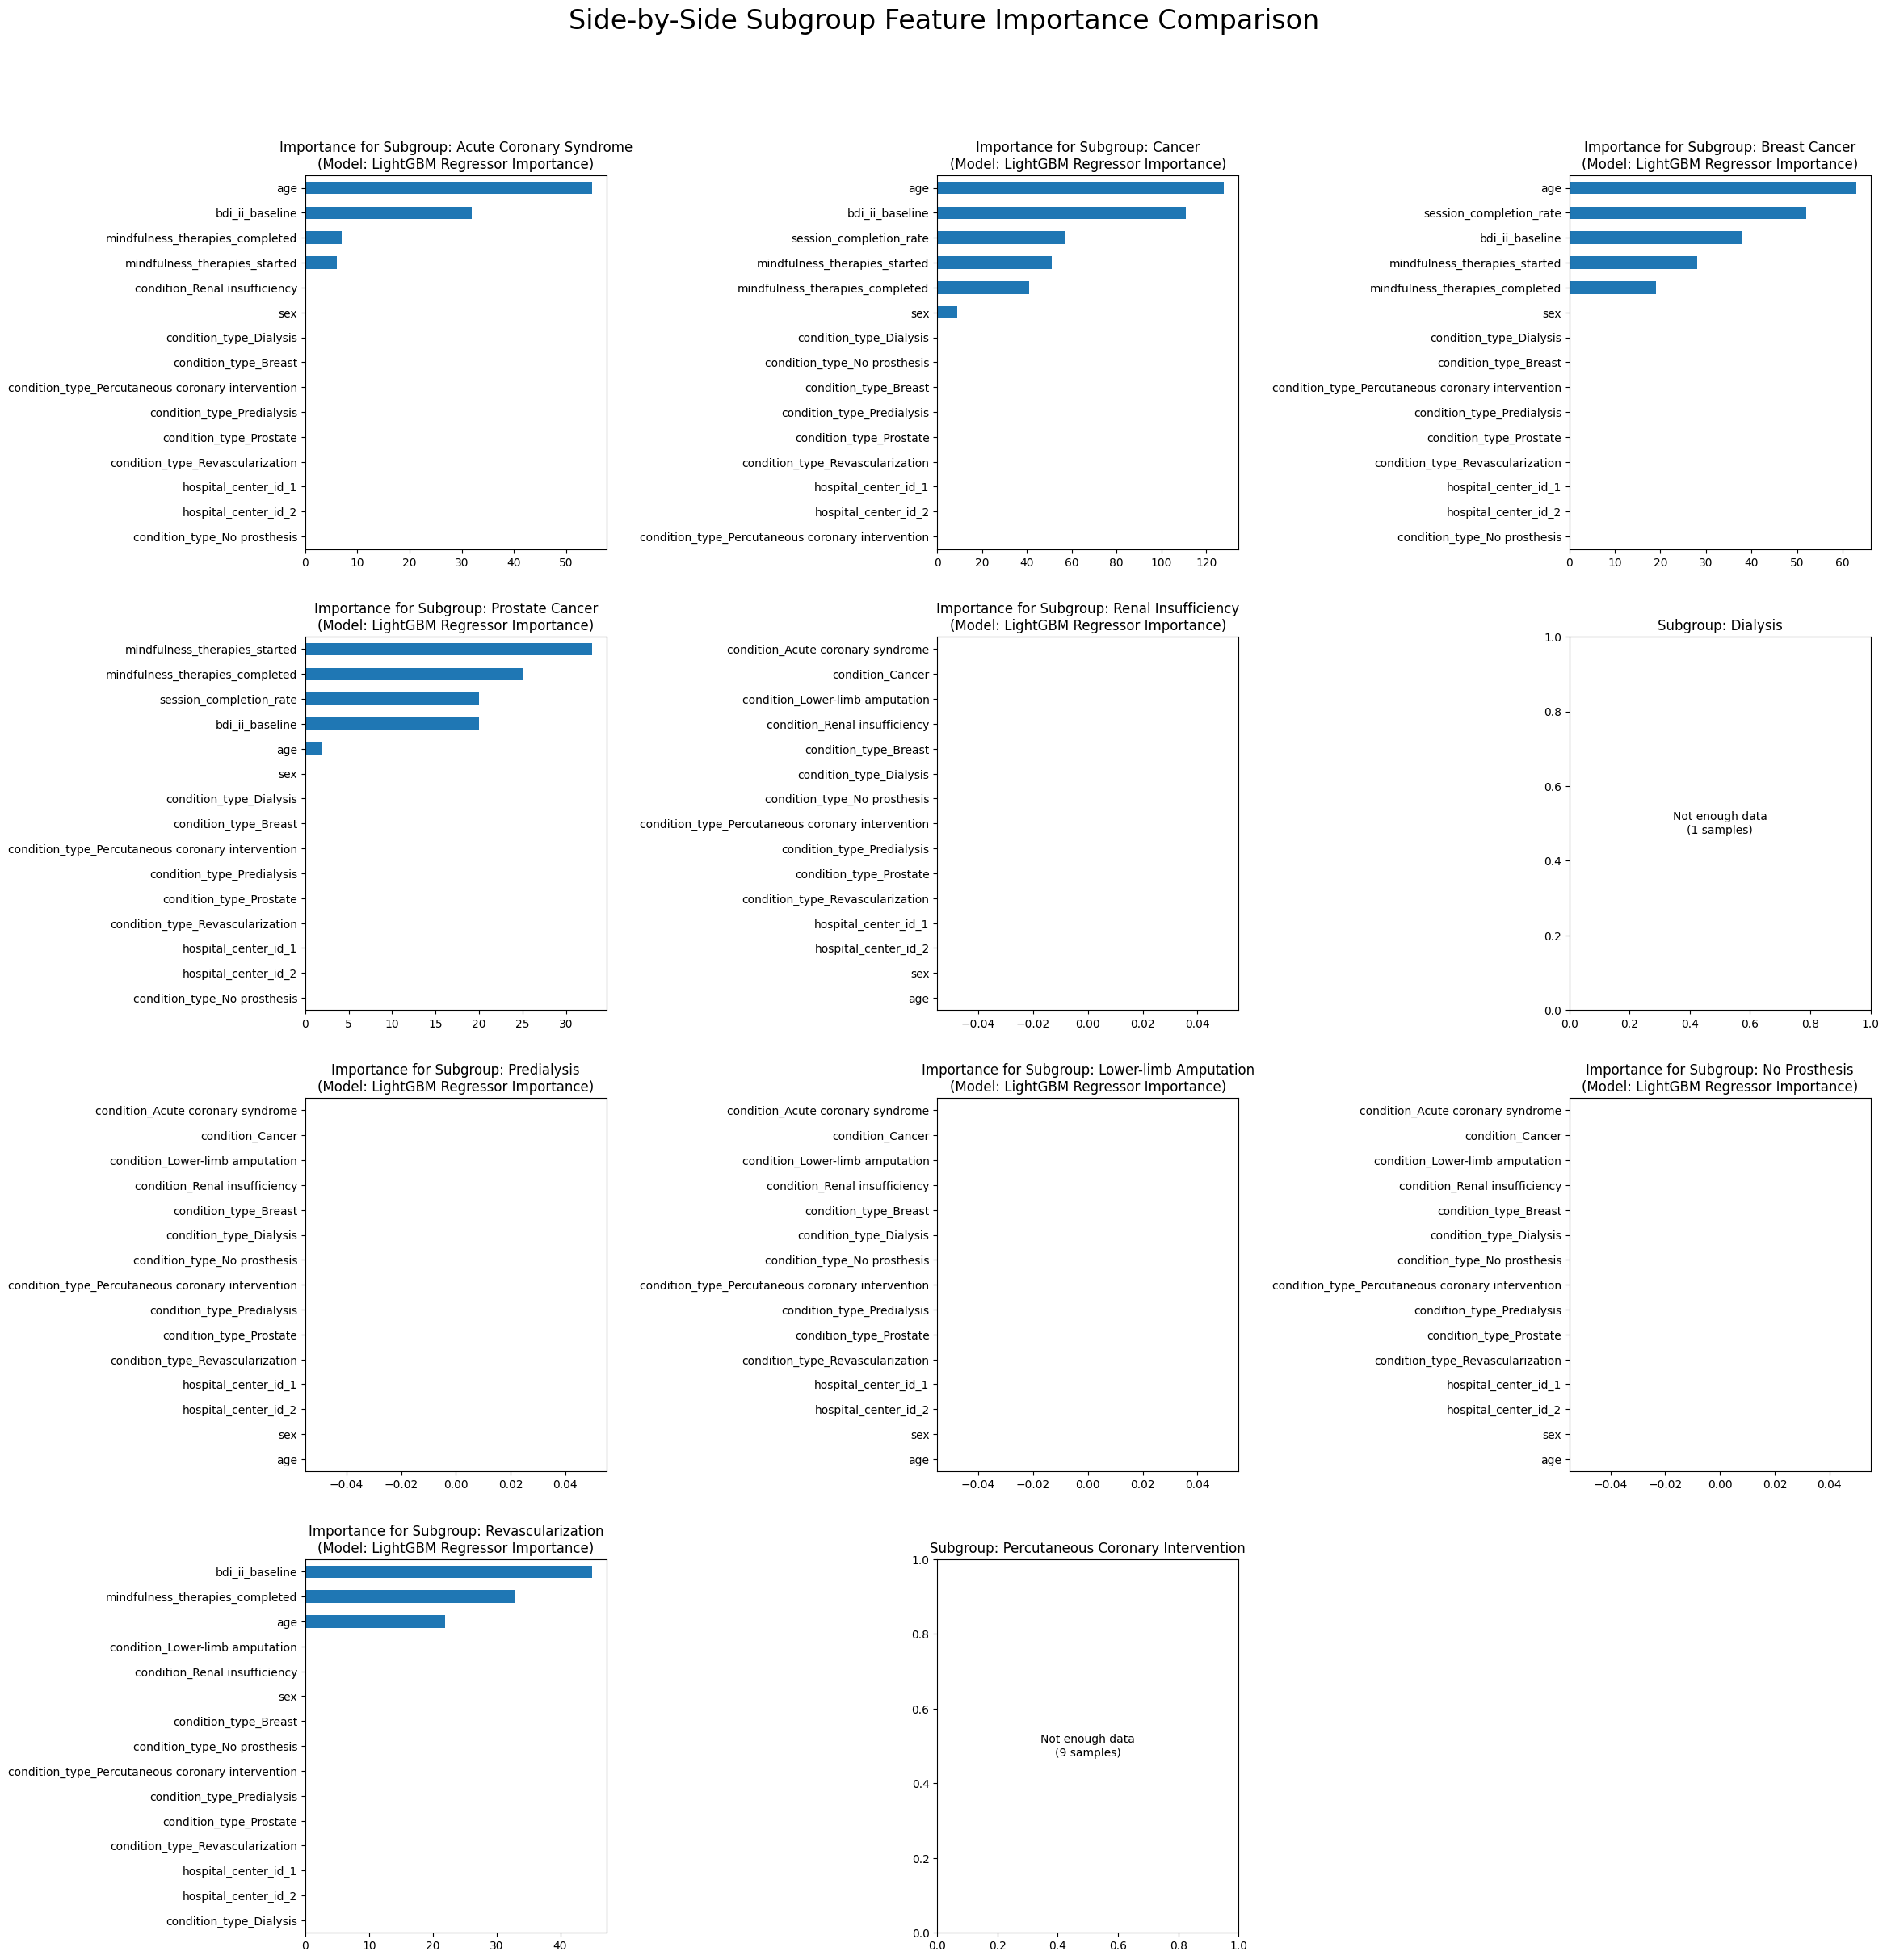

In [25]:
run_subgroup_analysis(df_final, 'bdi_ii_after_intervention_12w')


  FINAL MODELING FOR: bdi_ii_follow_up_24w

Training on 168 samples, testing on 42 samples.

--- Model Performance Results ---
              Model      RMSE  R-squared
0          LightGBM  5.044623   0.522231
1          CatBoost  5.190964   0.494109
2     Random Forest  5.716617   0.386465
3           XGBoost  5.998058   0.324567
4  Ridge Regression  6.033422   0.316579

BEST GlobalMODEL: LightGBM with RMSE: 5.0446
--- Generating Feature Importance for Best Global Model (LightGBM) ---


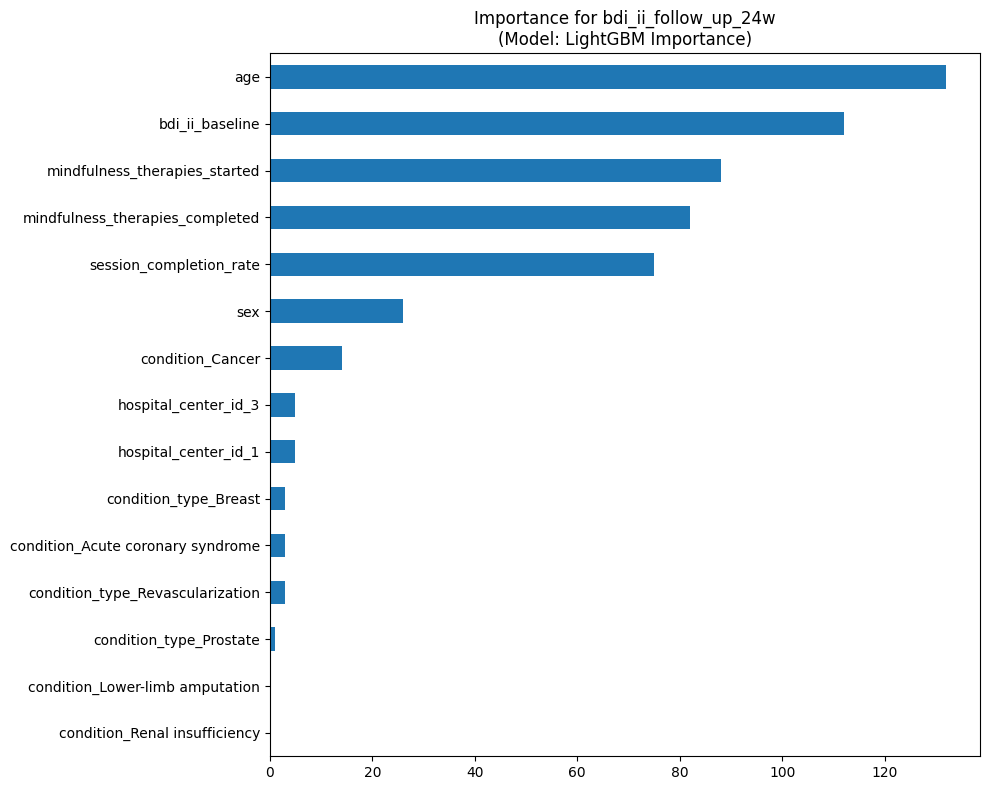

In [26]:
final_train_and_evaluate(df_final, 'bdi_ii_follow_up_24w')


  RUNNING DETAILED SUBGROUP ANALYSIS FOR: bdi_ii_follow_up_24w

--- Analyzing Subgroup: Acute Coronary Syndrome ---
Found 52 samples for this group.
--- Analyzing Subgroup: Cancer ---
Found 127 samples for this group.
--- Analyzing Subgroup: Breast Cancer ---
Found 79 samples for this group.
--- Analyzing Subgroup: Prostate Cancer ---
Found 49 samples for this group.
--- Analyzing Subgroup: Renal Insufficiency ---
Found 19 samples for this group.
--- Analyzing Subgroup: Dialysis ---
--- Analyzing Subgroup: Predialysis ---
Found 17 samples for this group.
--- Analyzing Subgroup: Lower-limb Amputation ---
Found 12 samples for this group.
--- Analyzing Subgroup: No Prosthesis ---
Found 12 samples for this group.
--- Analyzing Subgroup: Revascularization ---
Found 43 samples for this group.
--- Analyzing Subgroup: Percutaneous Coronary Intervention ---


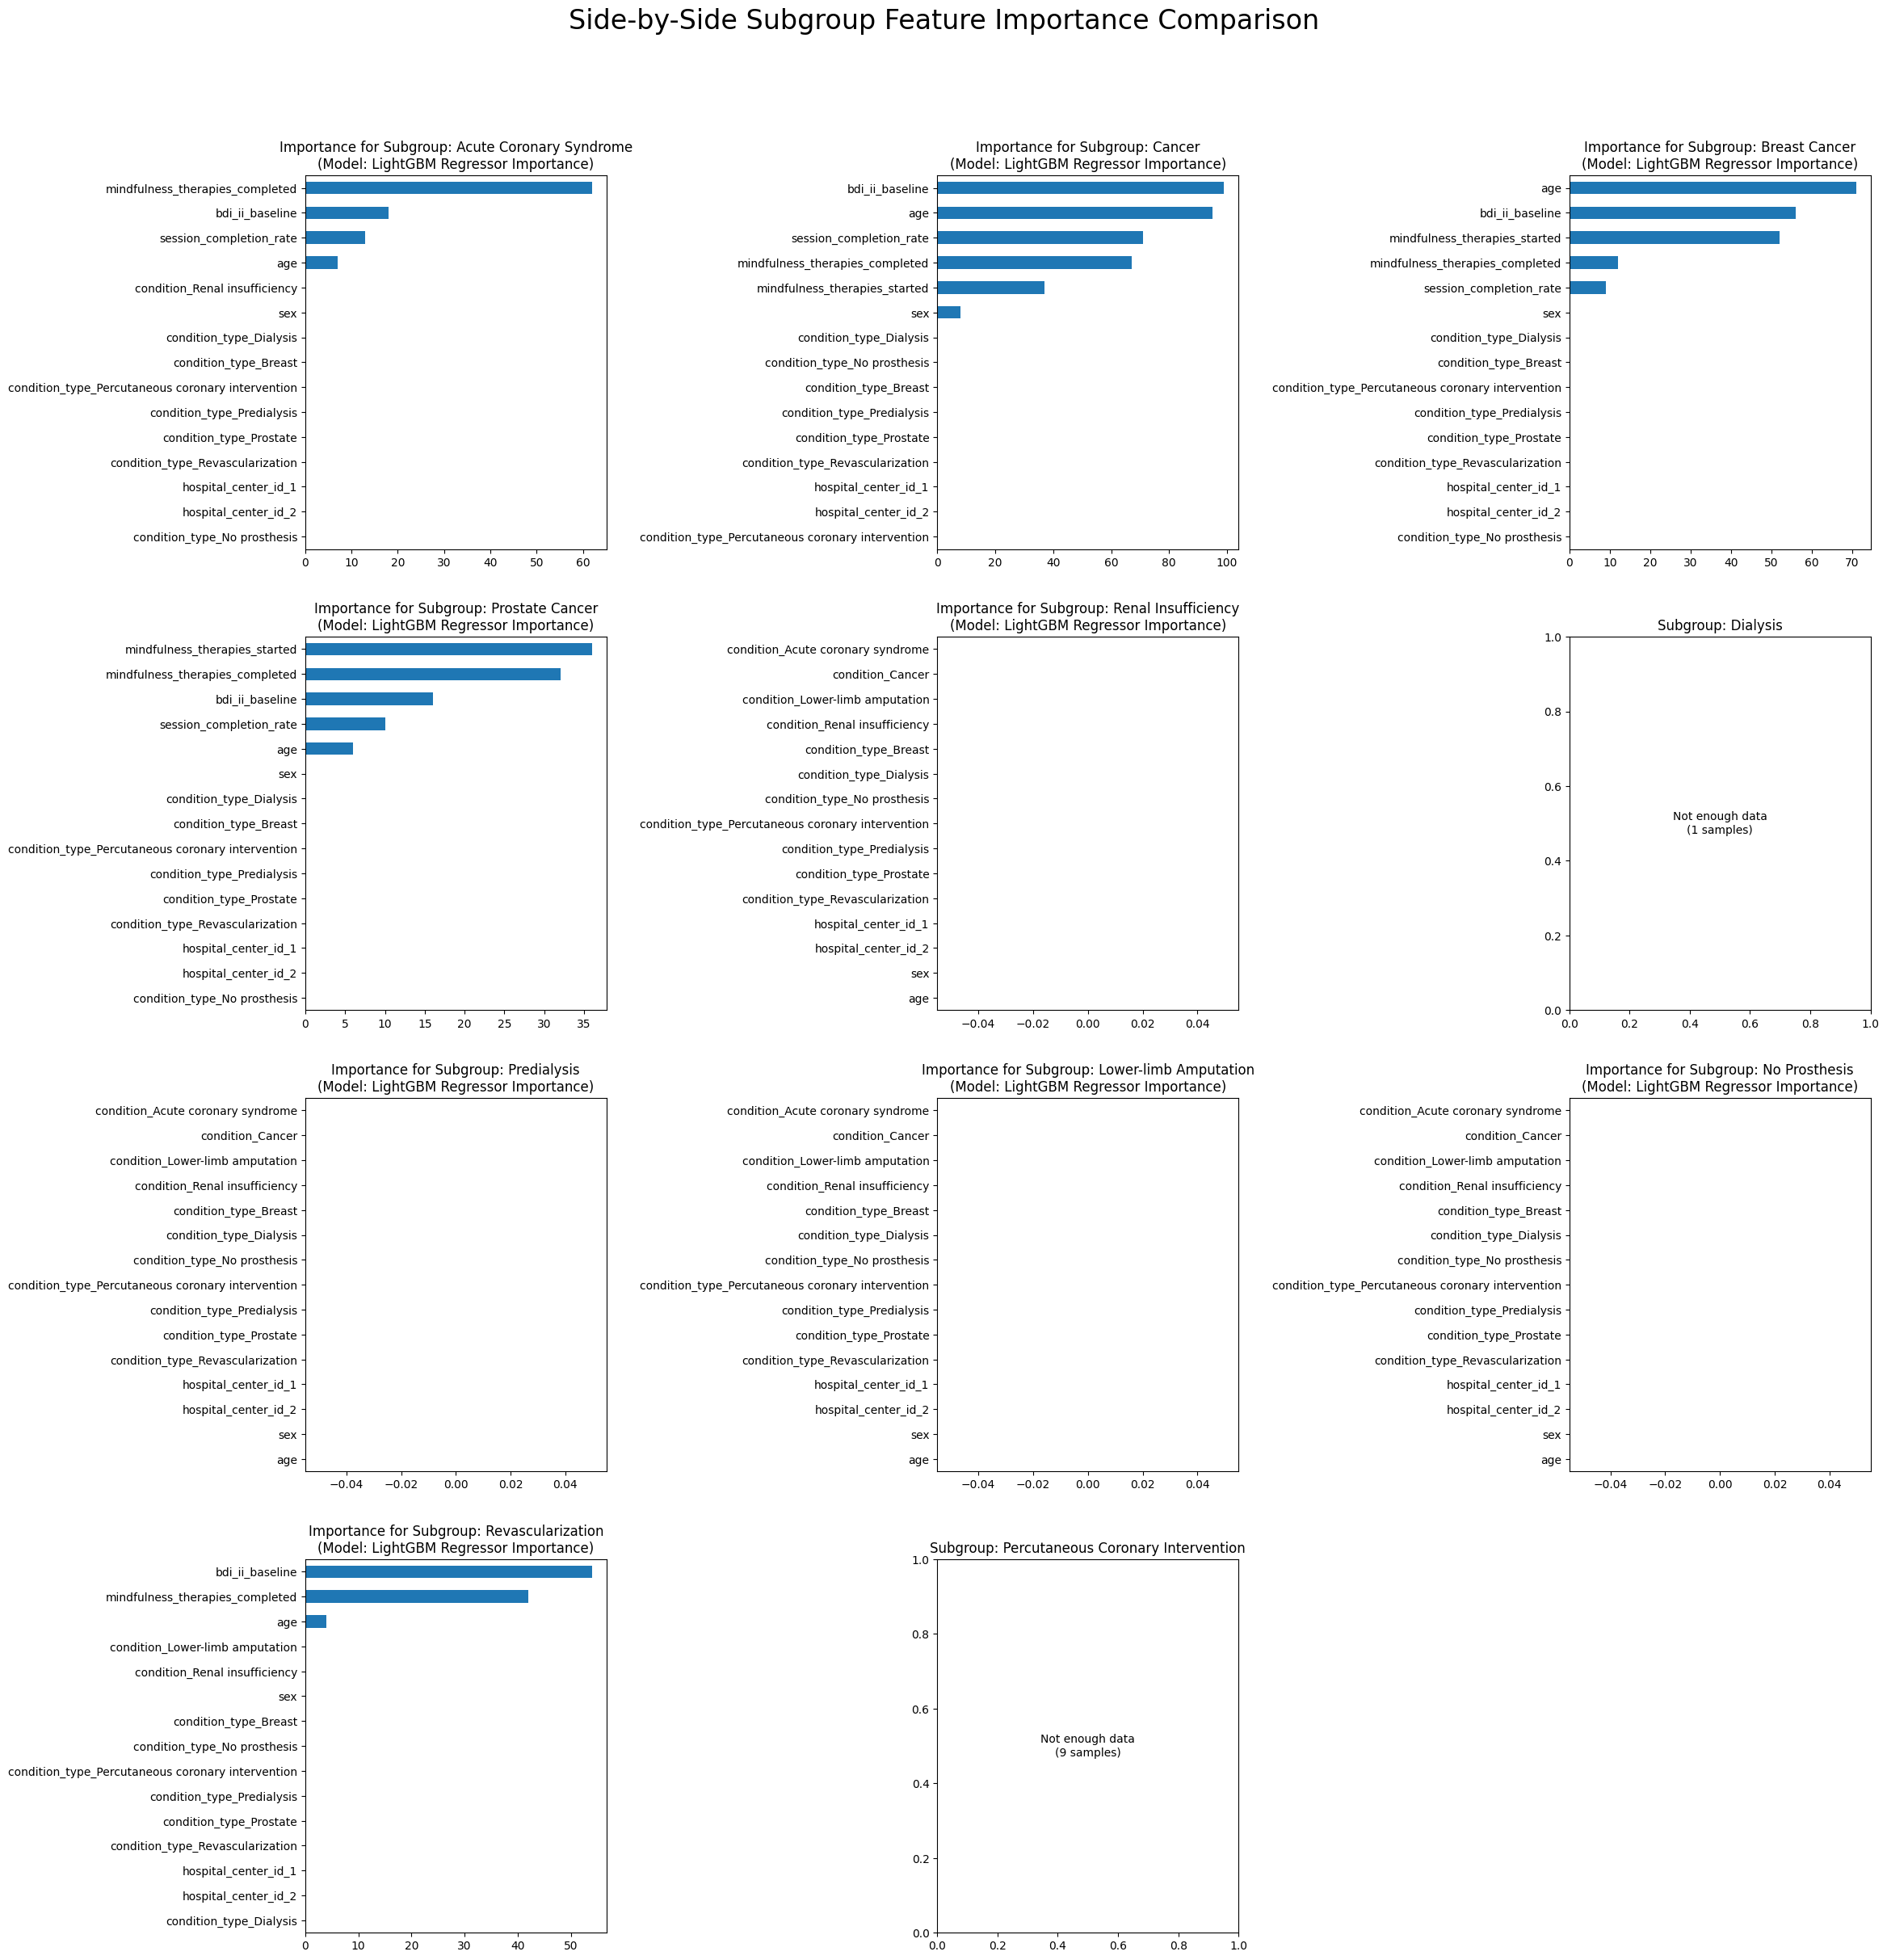

In [27]:
run_subgroup_analysis(df_final, 'bdi_ii_follow_up_24w')


  GENERATING FOCUSED SUBGROUP COMPARISON PLOT



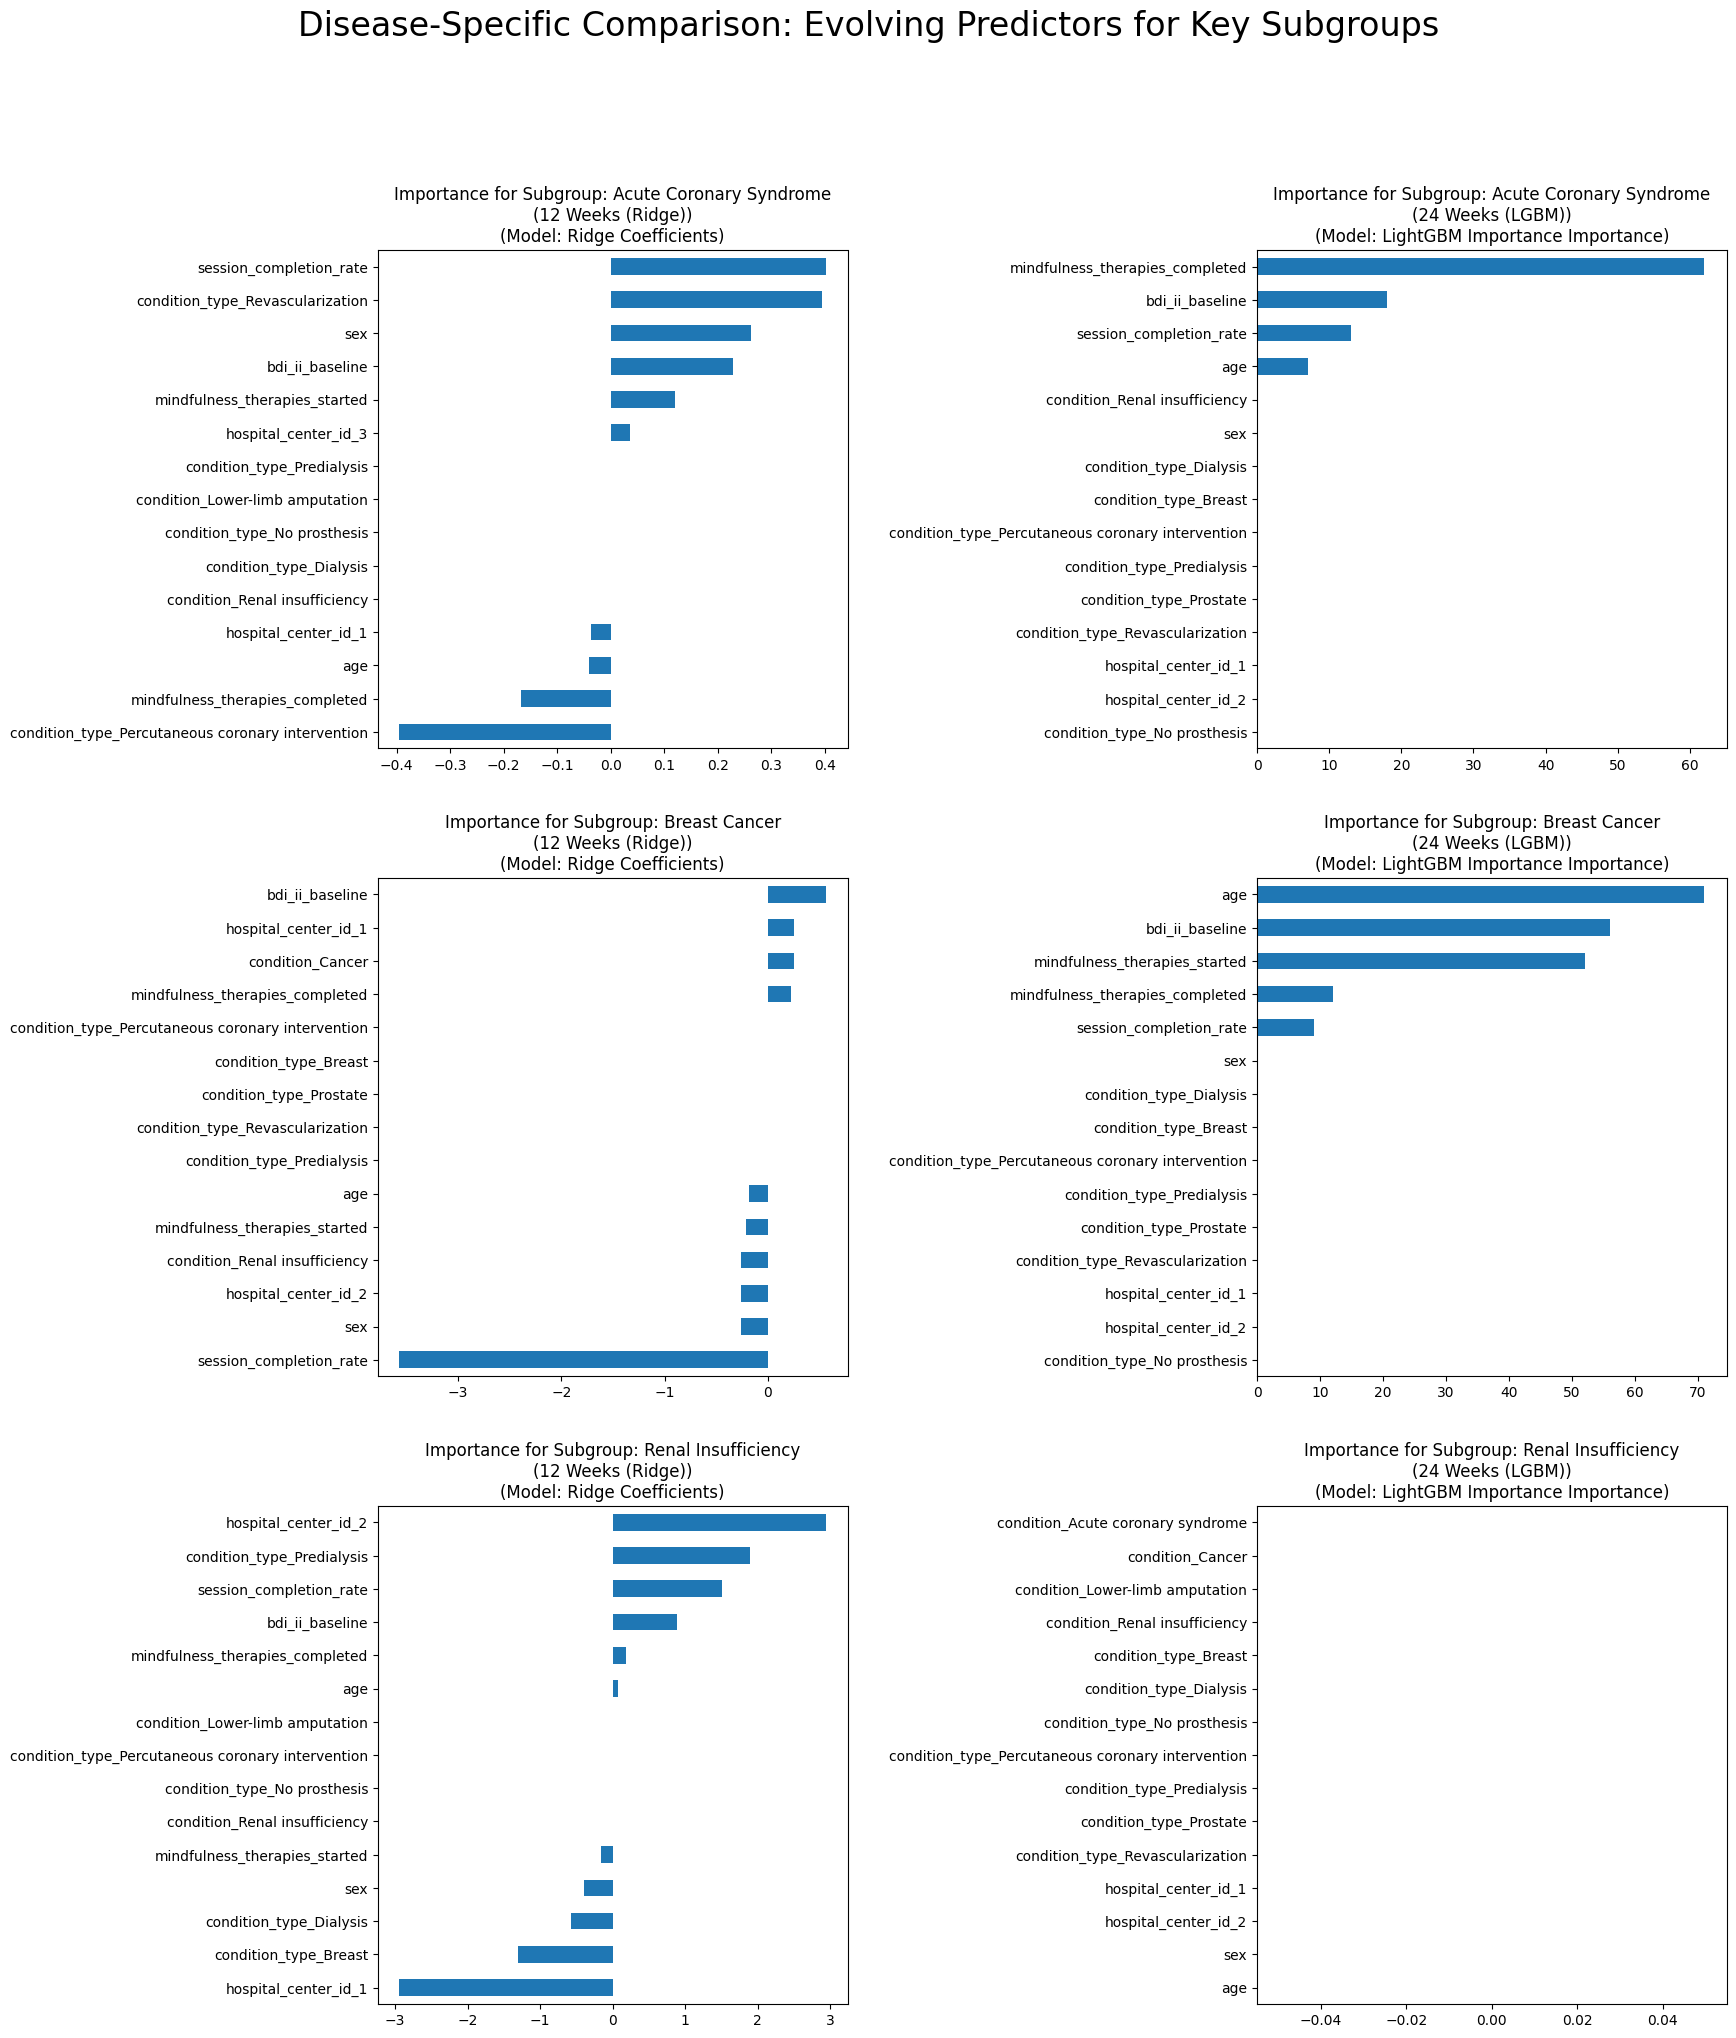

In [28]:
generate_focused_subgroup_plot(df_final)


  GENERATING DISEASE-SPECIFIC COMPARISON PLOT (12 WEEKS)



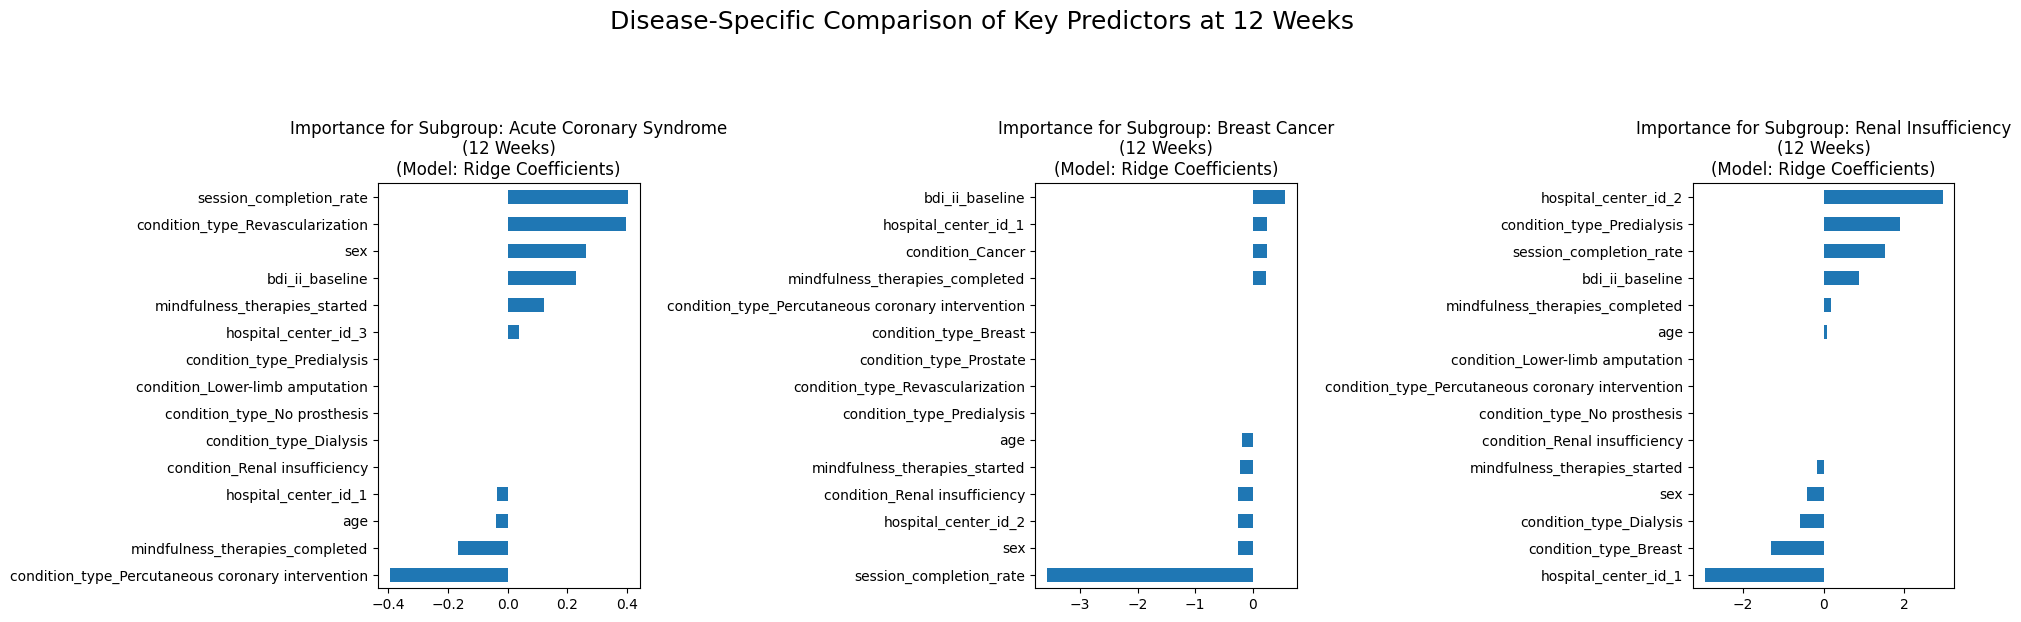

In [29]:
generate_disease_specific_plot(df_final)


  GENERATING TEMPORAL SHIFT PLOT (ACUTE CORONARY SYNDROME)



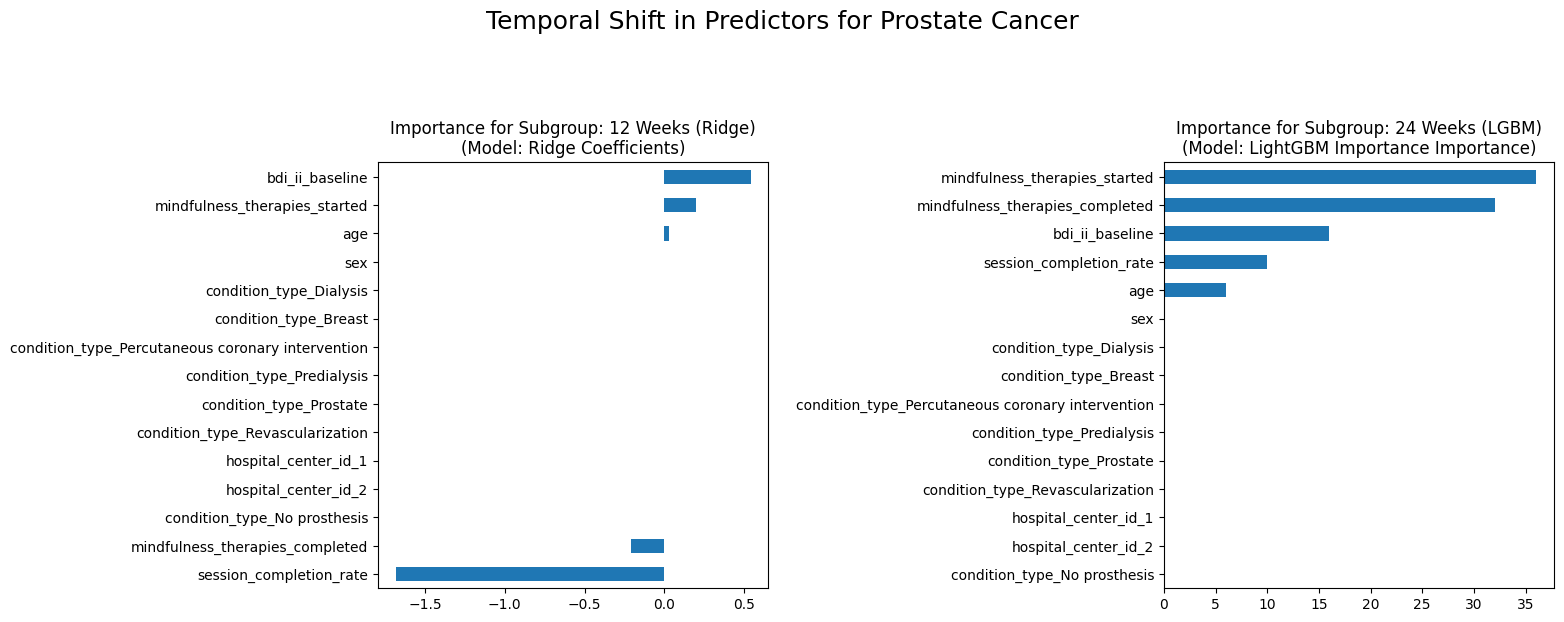

In [30]:
generate_temporal_shift_plot(df_final)


  GENERATING TEMPORAL SHIFT PLOT (ACUTE CORONARY SYNDROME)



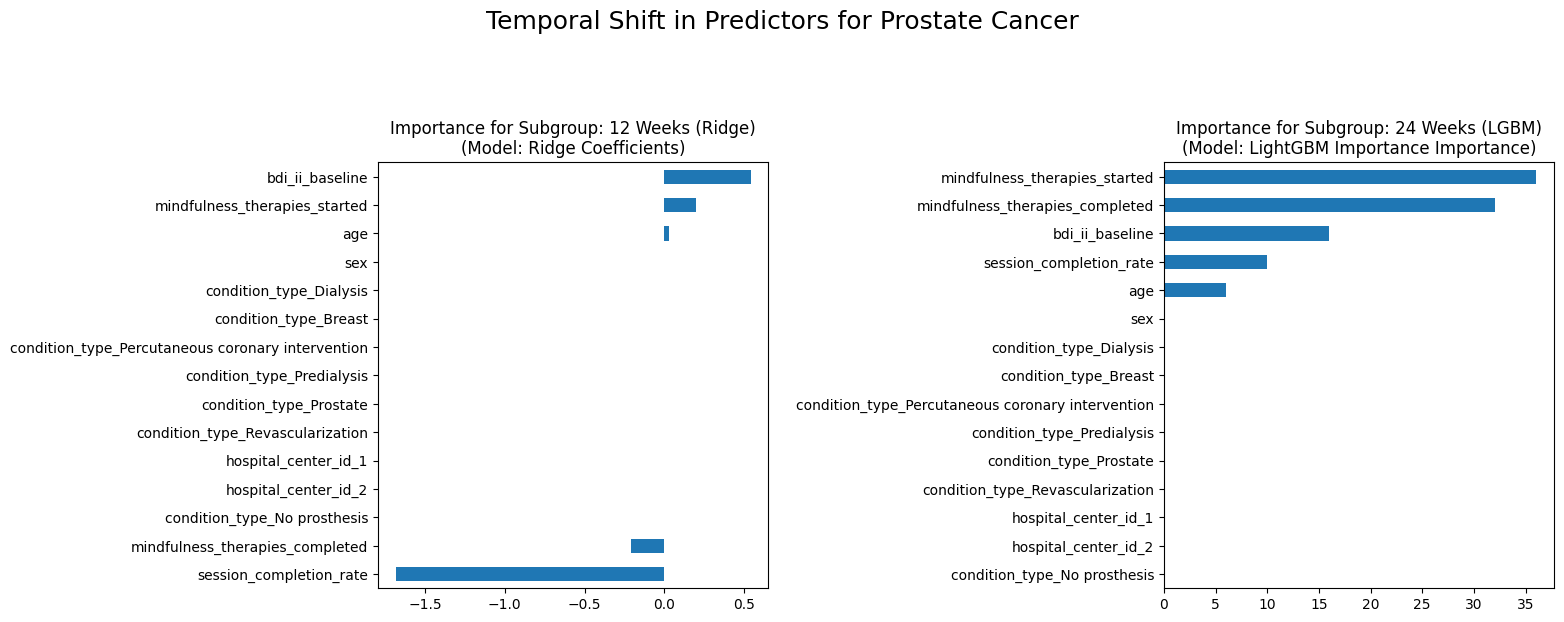

In [31]:
generate_temporal_shift_plot(df_final)

In [41]:
def run_hierarchical_analysis(data, parent_condition_col, subtypes_dict, target_column, time_period):
    """
    Performs a hierarchical analysis on a parent condition by training and comparing
    dedicated models for its specific subtypes.

    Args:
        data (pd.DataFrame): The full, imputed dataset.
        parent_condition_col (str): The column name for the broad condition (e.g., 'condition_Cancer').
        subtypes_dict (dict): A dictionary mapping readable names to subtype columns
                              (e.g., {'Breast Cancer': 'condition_type_Breast'}).
        target_column (str): The target variable for prediction.
        time_period (str): A string for the plot title (e.g., "12 Weeks").
    """
    print("\n" + "="*40)
    print(f"  RUNNING HIERARCHICAL ANALYSIS FOR: {parent_condition_col}")
    print("="*40 + "\n")

    # 1. Create the "parent" dataframe for the broad condition
    parent_df = data[data[parent_condition_col] == 1].copy()
    
    if len(parent_df) == 0:
        print(f"No data found for the parent condition: {parent_condition_col}. Skipping.")
        return

    # 2. Create a plotting grid (1 row, as many columns as subtypes)
    num_subtypes = len(subtypes_dict)
    fig, axes = plt.subplots(1, num_subtypes, figsize=(num_subtypes * 8, 7))
    
    # Ensure 'axes' is always a list, even if there's only one subtype
    if num_subtypes == 1:
        axes = [axes]

    # 3. Loop through each subtype, train a model, and plot
    for i, (subtype_name, subtype_col) in enumerate(subtypes_dict.items()):
        ax = axes[i]
        print(f"--- Analyzing Subtype: {subtype_name} ---")

        # Filter the parent dataframe for the specific subtype
        subtype_df = parent_df[parent_df[subtype_col] == 1].copy()

        if len(subtype_df) < 10:
            ax.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
            ax.set_title(f'{subtype_name}\n({time_period})')
            continue

        y_sub = subtype_df[target_column]
        cols_to_exclude = ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w', 'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w']
        X_sub = subtype_df.drop(columns=[col for col in cols_to_exclude if col in subtype_df.columns])

        # We'll use Ridge for a clear comparison of coefficients at 12 weeks
        model = Ridge(random_state=42)
        model.fit(X_sub, y_sub)

        run_interpretation_modified( # Your existing interpretation function
            model=model,
            model_name="Ridge Regression",
            X_data=X_sub,
            target_name="",
            subgroup_title=f'{subtype_name}\n({time_period})',
            ax=ax
        )

    # 4. Final figure adjustments
    parent_name = parent_condition_col.replace('condition_', '').replace('_', ' ')
    fig.suptitle(f'Hierarchical Analysis: Predictors for {parent_name} Subtypes', fontsize=20, y=1.08)
    plt.tight_layout(pad=2.0)
    # plt.savefig(f'hierarchical_{parent_condition_col}.png', dpi=300, bbox_inches='tight')
    plt.show()




  RUNNING HIERARCHICAL ANALYSIS FOR: condition_Cancer

--- Analyzing Subtype: Breast Cancer ---
--- Analyzing Subtype: Prostate Cancer ---


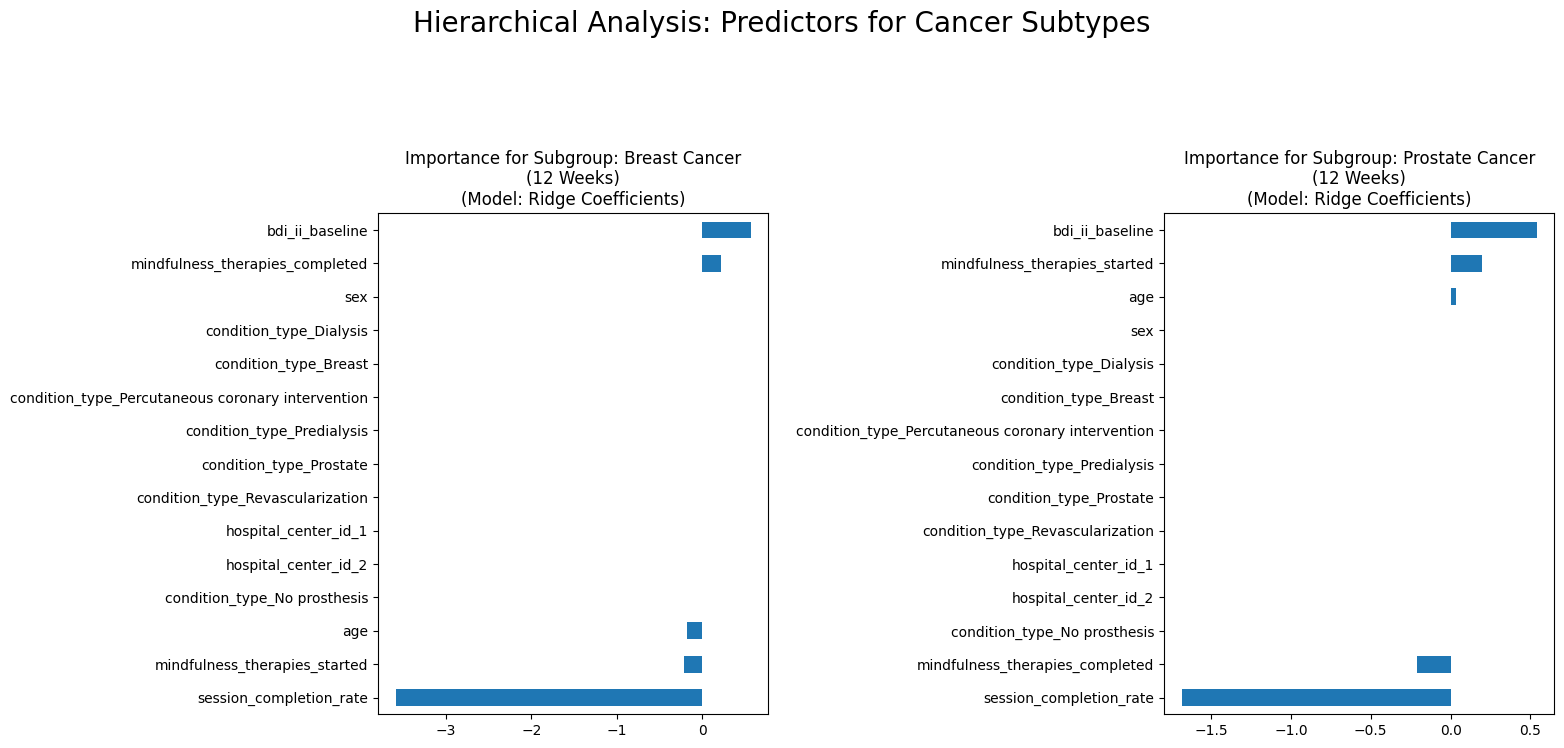

In [42]:
# Define the cancer subtypes
cancer_subtypes = {
    'Breast Cancer': 'condition_type_Breast',
    'Prostate Cancer': 'condition_type_Prostate'
}

# Run the analysis for the 'Cancer' condition at 12 weeks
run_hierarchical_analysis(
    data=df_final,
    parent_condition_col='condition_Cancer',
    subtypes_dict=cancer_subtypes,
    target_column='bdi_ii_after_intervention_12w',
    time_period="12 Weeks"
)


  RUNNING HIERARCHICAL ANALYSIS FOR: condition_Renal insufficiency

--- Analyzing Subtype: Dialysis ---
--- Analyzing Subtype: Predialysis ---


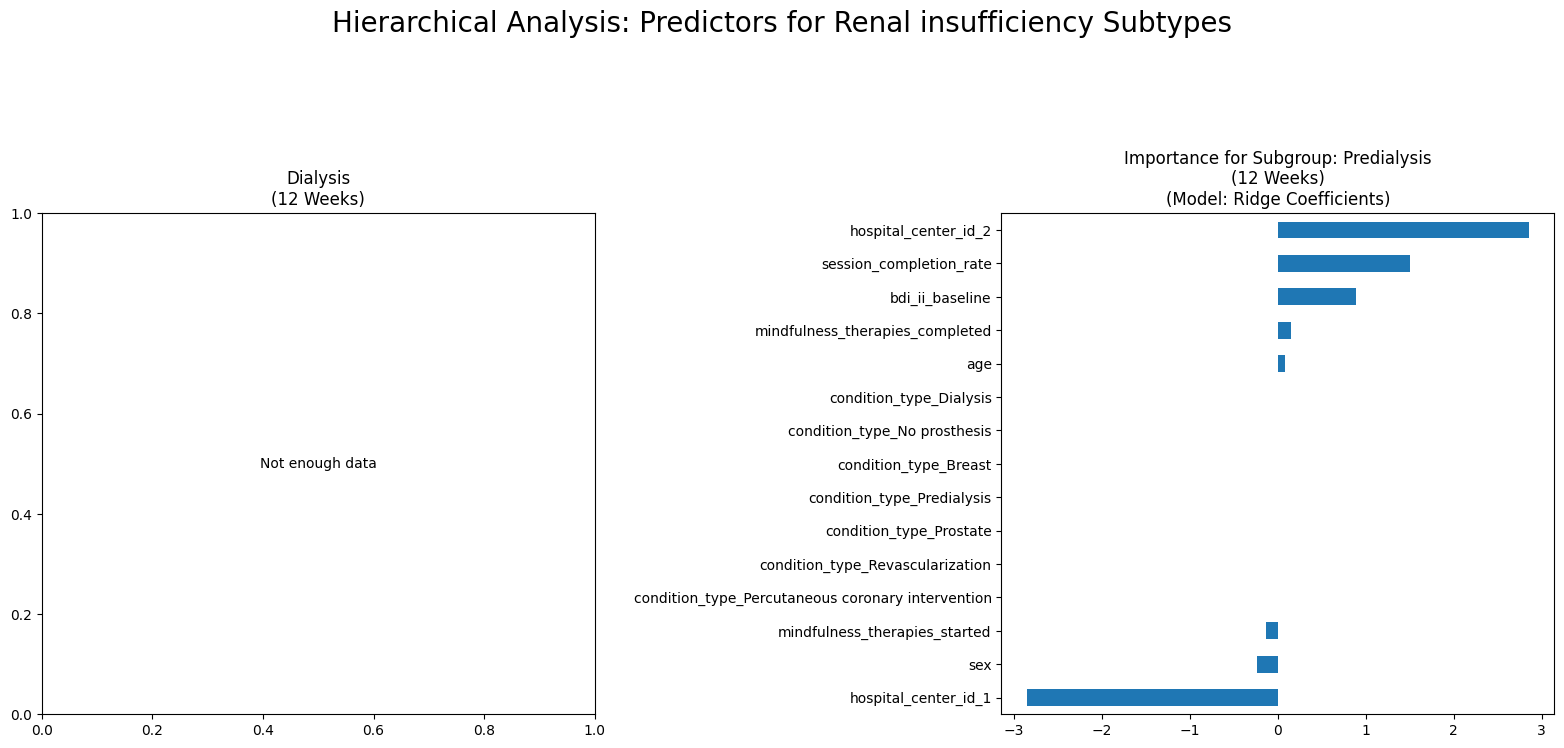

In [43]:
renal_subtypes = {
    'Dialysis': 'condition_type_Dialysis',
    'Predialysis': 'condition_type_Predialysis'
}

run_hierarchical_analysis(
    data=df_final,
    parent_condition_col='condition_Renal insufficiency',
    subtypes_dict=renal_subtypes,
    target_column='bdi_ii_after_intervention_12w',
    time_period="12 Weeks"
)


  RUNNING HIERARCHICAL ANALYSIS FOR: condition_Acute coronary syndrome

--- Analyzing Subtype: Revascularization ---
--- Analyzing Subtype: Percutaneous coronary intervention ---


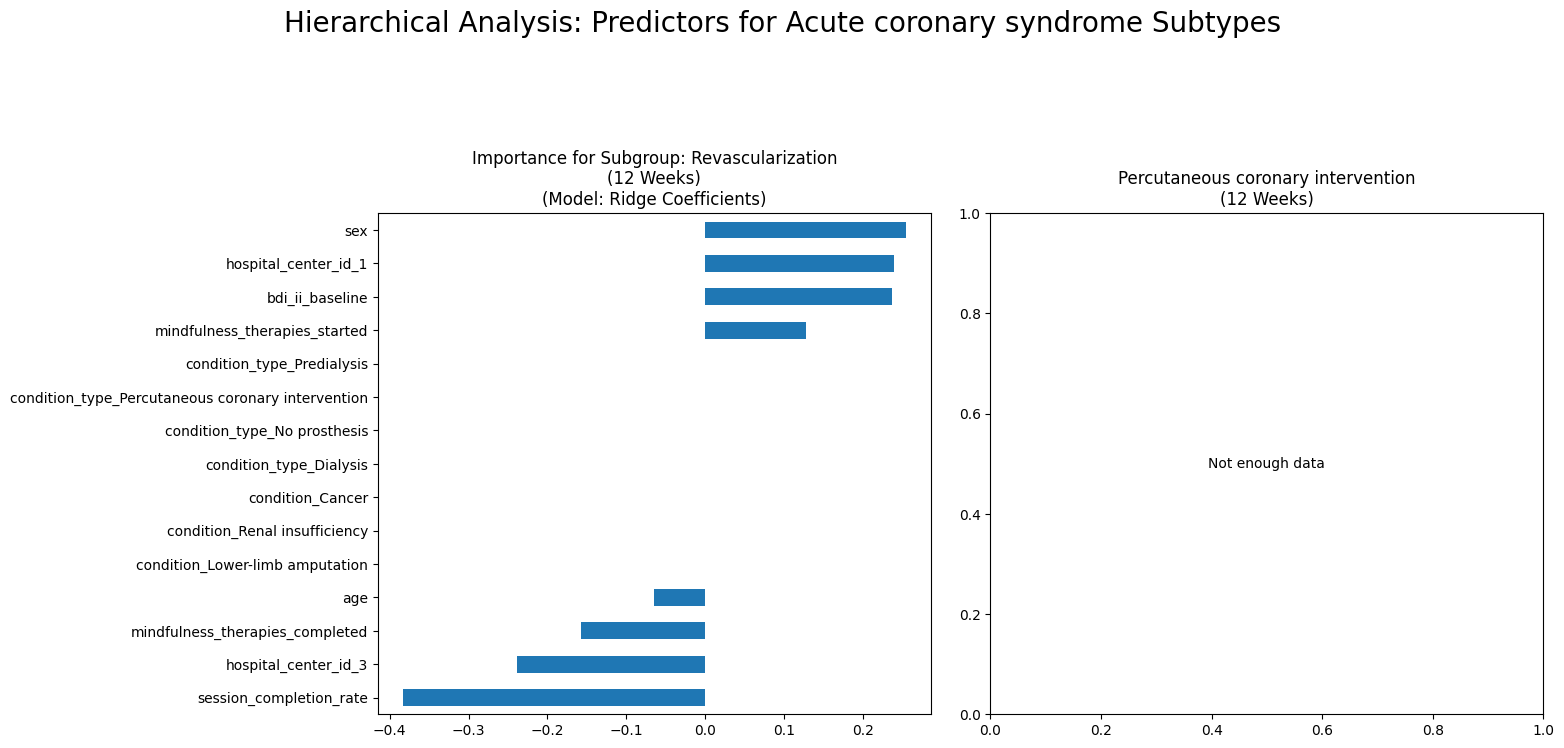

In [35]:
acute_coronary_syndrome_subtypes = {
    'Revascularization': 'condition_type_Revascularization',
    'Percutaneous coronary intervention': 'condition_type_Percutaneous coronary intervention'
}

run_hierarchical_analysis(
    data=df_final,
    parent_condition_col='condition_Acute coronary syndrome',
    subtypes_dict=acute_coronary_syndrome_subtypes,
    target_column='bdi_ii_after_intervention_12w',
    time_period="12 Weeks"
)


  RUNNING HIERARCHICAL ANALYSIS FOR: condition_Lower-limb amputation

--- Analyzing Subtype: No Prosthesis ---


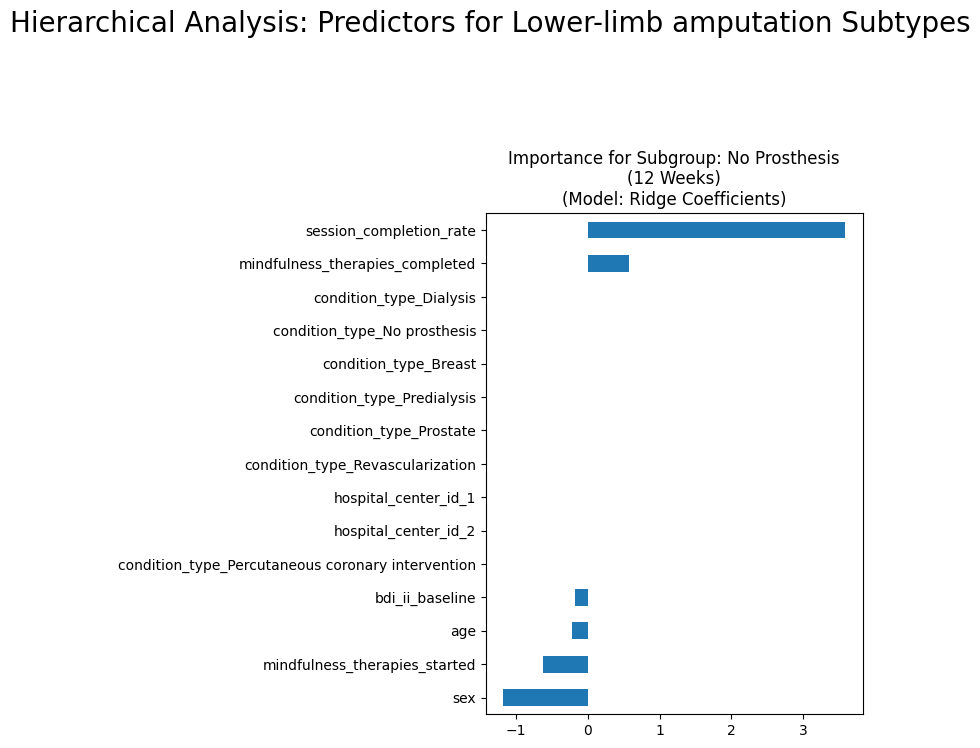

In [36]:
lower_limb_amputation_subtypes = {
    'No Prosthesis': 'condition_type_No prosthesis',
}

run_hierarchical_analysis(
    data=df_final,
    parent_condition_col='condition_Lower-limb amputation',
    subtypes_dict=lower_limb_amputation_subtypes,
    target_column='bdi_ii_after_intervention_12w',
    time_period="12 Weeks"
)

In [44]:
def generate_mixed_subtype_plot(data):
    """
    Generates a focused 1x3 comparison plot for specific, successful subtypes
    from different parent conditions to highlight unique patterns.
    """
    print("\n" + "="*40)
    print("  GENERATING MIXED SUBTYPE COMPARISON PLOT")
    print("="*40 + "\n")

    # Define the specific subtypes to plot
    subtypes_to_plot = {
        'Predialysis': ('condition_Renal insufficiency', 'condition_type_Predialysis'),
        'No Prosthesis': ('condition_Lower-limb amputation', 'condition_type_No prosthesis'),
        'Revascularization': ('condition_Acute coronary syndrome', 'condition_type_Revascularization')
    }

    # Create a 1x3 grid for the plots
    fig, axes = plt.subplots(1, 3, figsize=(24, 7))

    for i, (subtype_name, (parent_col, subtype_col)) in enumerate(subtypes_to_plot.items()):
        ax = axes[i]
        
        # Filter first by parent, then by subtype
        parent_df = data[data[parent_col] == 1].copy()
        subtype_df = parent_df[parent_df[subtype_col] == 1].copy()

        # Handle cases with not enough data, just in case
        if len(subtype_df) < 10:
            ax.text(0.5, 0.5, 'Not enough data', ha='center', va='center')
            ax.set_title(f'{subtype_name}\n(12 Weeks)')
            continue

        y_sub = subtype_df['bdi_ii_after_intervention_12w']
        cols_to_exclude = ['bdi_ii_after_intervention_12w', 'bdi_ii_follow_up_24w', 'delta_12w', 'delta_24w', 'pct_improve_12w', 'pct_improve_24w']
        X_sub = subtype_df.drop(columns=[col for col in cols_to_exclude if col in subtype_df.columns])

        model = Ridge(random_state=42)
        model.fit(X_sub, y_sub)
        
        # Use your existing, robust interpretation function
        run_interpretation_modified(
            model=model,
            model_name="Ridge Regression",
            X_data=X_sub,
            target_name="",
            subgroup_title=f'{subtype_name}\n(12 Weeks)',
            ax=ax
        )

    fig.suptitle('Hierarchical Analysis of Other Key Subtypes at 12 Weeks', fontsize=20, y=1.08)
    plt.tight_layout(pad=2.0)
    # plt.savefig('other_subtypes_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()


  GENERATING MIXED SUBTYPE COMPARISON PLOT



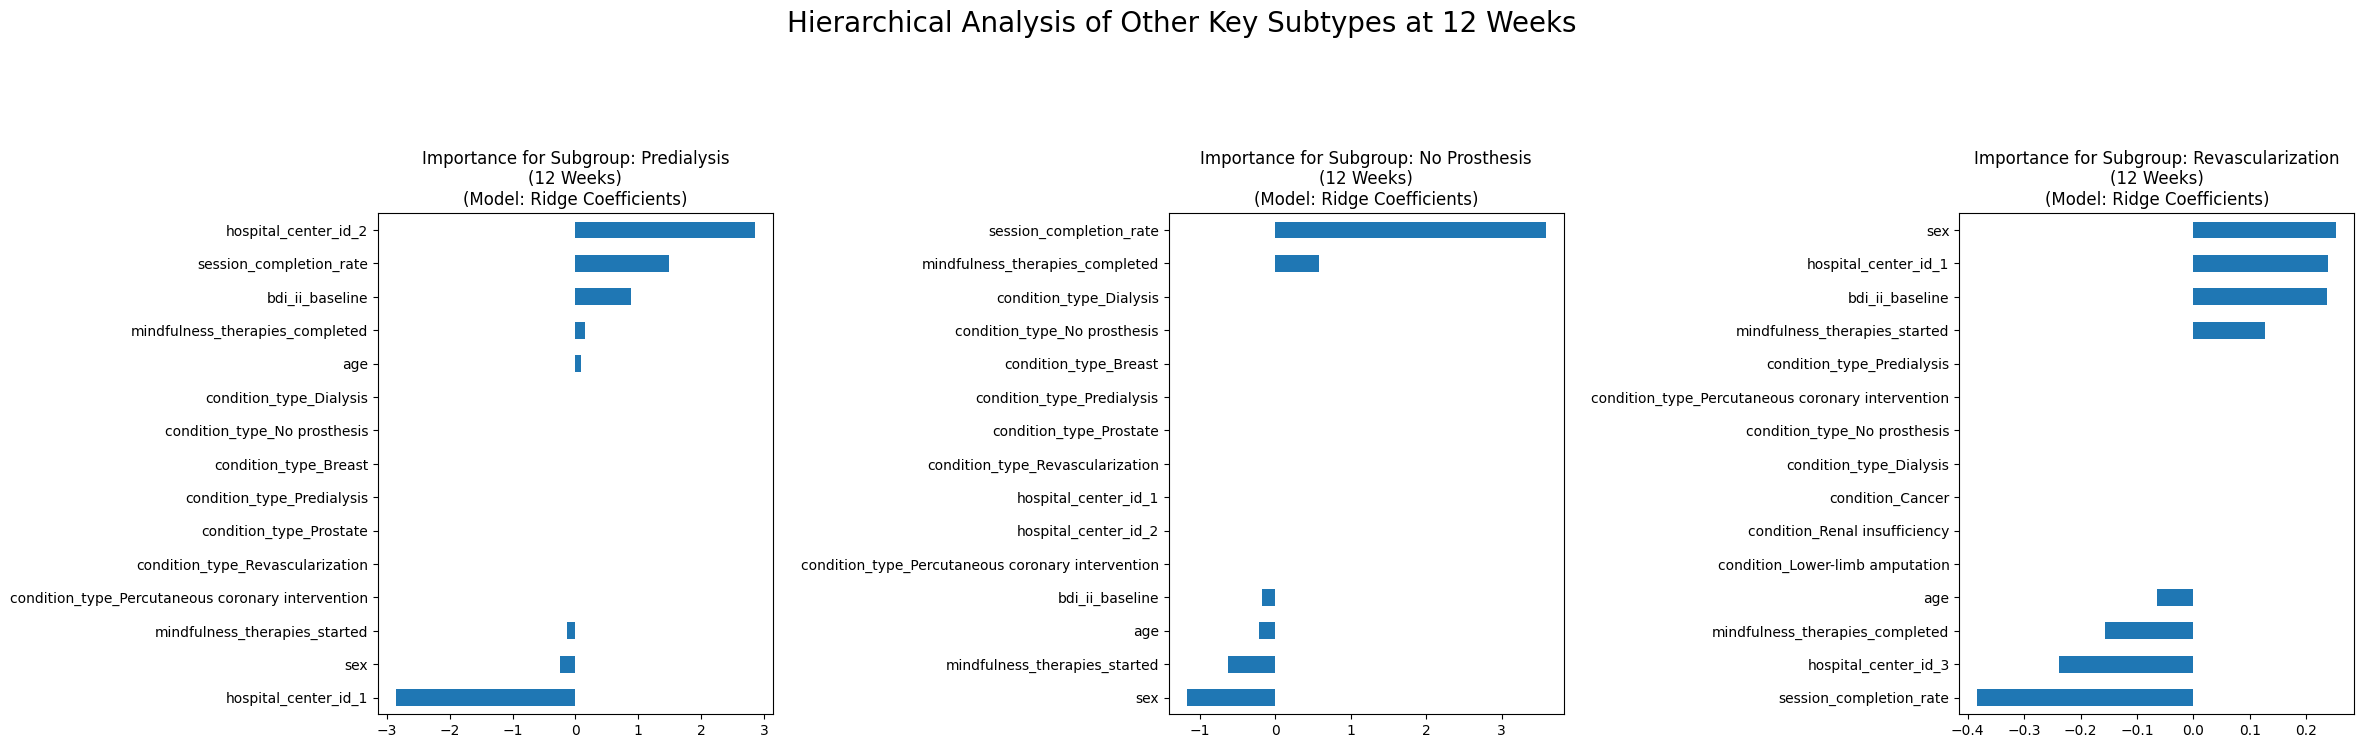

In [38]:
generate_mixed_subtype_plot(df_final)

In [45]:
def generate_comparative_scatter_plot(data):
    """
    Generates a scatter plot to visualize the relationship between therapy adherence
    and long-term improvement, correctly handling one-hot encoded cancer subtypes.
    """
    print("\n" + "="*40)
    print("  GENERATING COMPARATIVE SCATTER PLOT")
    print("="*40 + "\n")

    # Filter for only the cancer subtypes to make the plot clean
    cancer_df = data[data['condition_Cancer'] == 1].copy()
    
    # Calculate the 24-week improvement
    cancer_df['delta_24w'] = cancer_df['bdi_ii_baseline'] - cancer_df['bdi_ii_follow_up_24w']

    # --- NEW: RECONSTRUCT THE CATEGORICAL LABEL ---
    # Helper function to convert one-hot columns back to a single label
    def get_cancer_type(row):
        if row['condition_type_Breast'] == 1:
            return 'Breast Cancer'
        elif row['condition_type_Prostate'] == 1:
            return 'Prostate Cancer'
        else:
            return 'Other Cancer' # Fallback for any other types

    # Apply the function to create the new 'hue' column
    cancer_df['cancer_subtype_label'] = cancer_df.apply(get_cancer_type, axis=1)
    
    # --- PLOTTING WITH THE CORRECT HUE COLUMN ---
    plt.figure(figsize=(12, 8))
    sns.lmplot(
        data=cancer_df,
        x='session_completion_rate',
        y='delta_24w',
        hue='cancer_subtype_label', # Use the newly created label column
        palette={'Breast Cancer': 'blue', 'Prostate Cancer': 'orange'},
        height=7,
        aspect=1.5,
        scatter_kws={'alpha': 0.6}
    )
    
    plt.title('Therapy Adherence vs. Long-Term Improvement by Cancer Subtype', fontsize=16)
    plt.xlabel('Session Completion Rate', fontsize=12)
    plt.ylabel('Improvement in BDI-II Score at 24 Weeks', fontsize=12)
    plt.grid(True)
    # plt.savefig('comparative_scatter_plot.png', dpi=300, bbox_inches='tight')
    plt.show()



  GENERATING COMPARATIVE SCATTER PLOT



<Figure size 1200x800 with 0 Axes>

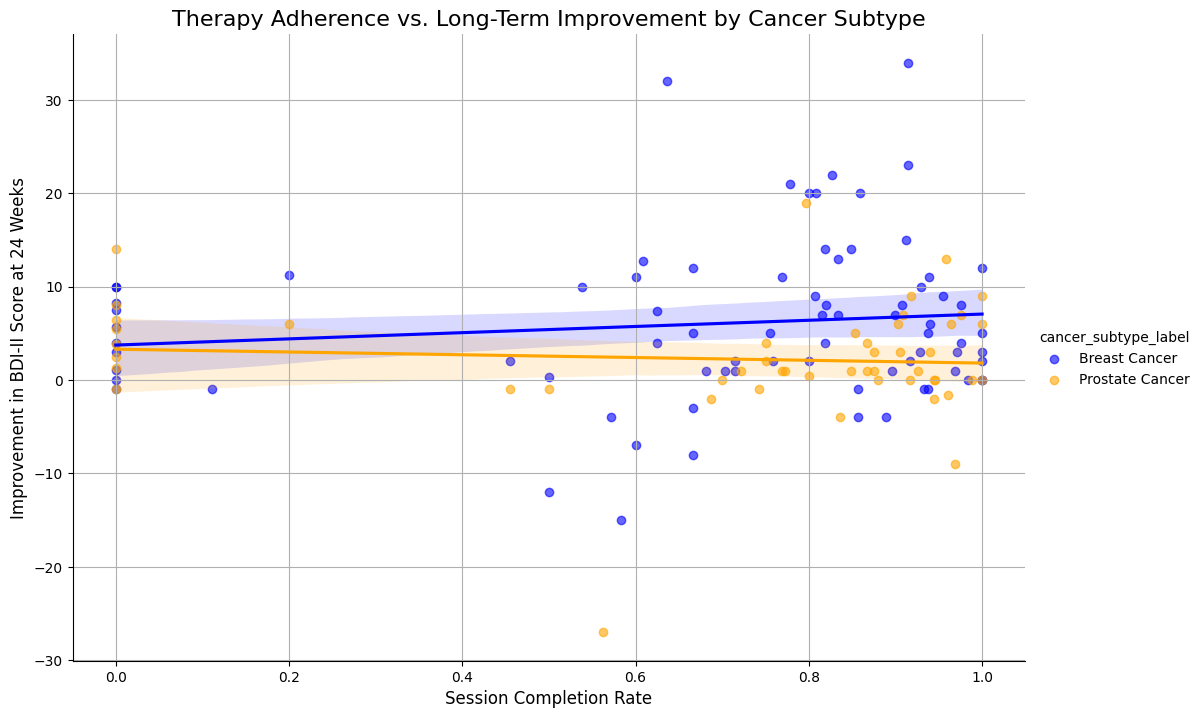

In [40]:
generate_comparative_scatter_plot(df_final)